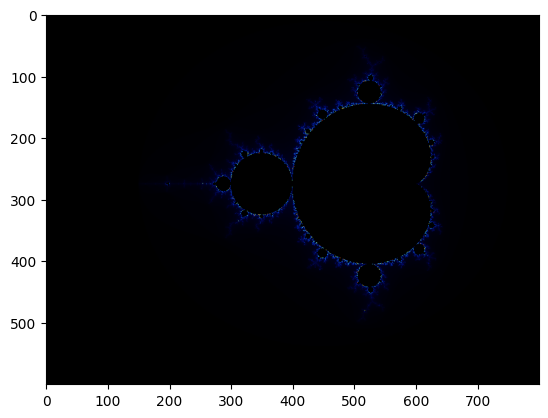

In [2]:
import pyopencl as cl
import numpy as np

# 获取所有平台和设备
platforms = cl.get_platforms()
devices = []
for platform in platforms:
    devices.extend(platform.get_devices())

# 过滤支持双精度浮点数的设备
supported_devices = [device for device in devices if 'cl_khr_fp64' in device.extensions]

if not supported_devices:
    raise RuntimeError("No devices with double precision floating point support found.")

# 创建上下文和队列
contexts = [cl.Context([device]) for device in supported_devices]
queues = [cl.CommandQueue(context) for context in contexts]

# 加载内核代码
kernel_code = """
#pragma OPENCL EXTENSION cl_khr_fp64 : enable

__kernel void mandelbrot(__global uchar4* output, const int width, const int height, const double x_start, const double x_finish, const double y_start, const double y_finish, const double center_x, const double center_y) {
    int x = get_global_id(0);
    int y = get_global_id(1);

    if (x >= width || y >= height) {
        return;
    }

    double dx = (x_finish - x_start) / (width - 1);
    double dy = (y_finish - y_start) / (height - 1);
    double real = x * dx + x_start + center_x;
    double imag = y * dy + y_start + center_y;

    double c_real = real;
    double c_imag = imag;

    int max_iter = 1000;
    int iter = 0;

    for (int i = 0; i < max_iter; ++i) {
        double real2 = real * real - imag * imag + c_real;
        double imag2 = 2.0 * real * imag + c_imag;

        real = real2;
        imag = imag2;

        if (real * real + imag * imag > 4.0) {
            iter = i;
            break;
        }
    }

    uchar4 color;
    if (iter == max_iter) {
        color = (uchar4)(0, 0, 0, 255); // 黑色
    } else {
        double t = (double)iter / max_iter;
        color = (uchar4)(9 * (1 - t) * t * t * t * 255, 15 * (1 - t) * (1 - t) * t * t * 255, 8.5 * (1 - t) * (1 - t) * (1 - t) * t * 255, 255);
    }

    output[y * width + x] = color;
}
"""

# 编译内核
programs = [cl.Program(context, kernel_code).build() for context in contexts]

# 设置参数
width, height = 800, 600
x_start, x_finish = -2.0, 2.0
y_start, y_finish = -1.5, 1.5
center_x, center_y = -0.748766710846959, 0.123640847970064

# 创建输出缓冲区
output = np.zeros((height, width, 4), dtype=np.uint8)
buffers = [cl.Buffer(context, cl.mem_flags.WRITE_ONLY, output.nbytes) for context in contexts]

# 分配任务
chunk_size = height // len(supported_devices)
events = []
for i, (context, queue, program, buffer) in enumerate(zip(contexts, queues, programs, buffers)):
    y_offset = i * chunk_size
    y_end = height if i == len(supported_devices) - 1 else y_offset + chunk_size
    kernel = program.mandelbrot
    kernel.set_args(buffer, np.int32(width), np.int32(height), np.float64(x_start), np.float64(x_finish), np.float64(y_start + (y_offset * (y_finish - y_start) / height)), np.float64(y_start + (y_end * (y_finish - y_start) / height)), np.float64(center_x), np.float64(center_y))
    event = cl.enqueue_nd_range_kernel(queue, kernel, (width, y_end - y_offset), None)
    events.append(event)

# 等待所有事件完成
cl.wait_for_events(events)

# 读取结果
for i, (queue, buffer) in enumerate(zip(queues, buffers)):
    y_offset = i * chunk_size
    y_end = height if i == len(supported_devices) - 1 else y_offset + chunk_size
    cl.enqueue_copy(queue, output[y_offset:y_end], buffer)

# 显示结果
import matplotlib.pyplot as plt
plt.imshow(output)
plt.show()